In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
movie_gross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
name_basics = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
title_basics = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
title_crew = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
title_principals = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
title_ratings = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
movie_info= pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews= pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding='windows-1254')
budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

In [112]:
# print(movie_gross.keys())
# print(name_basics.keys())
# print(title_basics.keys())
# print(title_akas.keys())
# print(title_crew.keys())
# print(title_principals.keys())
# print(title_ratings.keys())
# print(movie_info.keys())
# print(budgets.keys())


In [8]:
# print(movie_gross.isna().sum())
# print(name_basics.isna().sum())
# print(title_basics.isna().sum())
# print(title_akas.isna().sum())
# print(title_crew.isna().sum())
# print(title_principals.isna().sum())
# print(title_ratings.isna().sum())
# print(movie_info.isna().sum())
# print(budgets.isna().sum())

In [3]:
#converting all values in budgets sheets to ints by removing commas and $
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$' , '')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',', '')
budgets['domestic_gross'] = budgets['domestic_gross'].astype(int)

budgets['production_budget'] = budgets['production_budget'].str.replace('$' , '')
budgets['production_budget'] = budgets['production_budget'].str.replace(',', '')
budgets['production_budget'] = budgets['production_budget'].astype(int)

budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$' , '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',', '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(int)


In [4]:
#creating new lines showing the difference between gross and cost, aka net, as well as a profit percentage calculation showing net over budget
budgets['domestic_net']= budgets['domestic_gross']- budgets['production_budget']
budgets['worldwide_net']= budgets['worldwide_gross']- budgets['production_budget']
budgets['profit_percentage'] = (budgets['worldwide_net']/budgets['production_budget'])*100

In [5]:
#combining ratings and basics to produce a dataframe that matches titles to ratings
titlerate = title_ratings.merge(title_basics, on= 'tconst', how= 'outer')
#dropping null values from the combined table
titlerate.dropna(subset= ['averagerating'], inplace = True)

In [9]:
#merging the two rotten tomatoes dataframes
tomatoes = rt_reviews.merge(movie_info, on='id', how='outer')

In [10]:
#changing the theater dates to datetime format so we can measure revenue against release date
tomatoes['theater_date'] = pd.to_datetime(tomatoes['theater_date'])
#dropping the date column to avoid confusion- it's the date of the review, whereas theater_date is the release
tomatoes.drop(['date'], axis = 1, inplace = True)
#reformatting the box office numbers to ints
tomatoes['box_office'] = tomatoes['box_office'].str.replace(',','')
#dropping null values here- it substantially cuts into our dataset and may not be the right choice, but I don't know how to switch to ints and leave null values. This column seems particularly valuable to map. Discuss?
tomatoes.dropna(subset= ['box_office'], inplace= True)
tomatoes['box_office'] = tomatoes['box_office'].astype(int)
#dropping null values from theater dates so we can graph dates against revenue later
tomatoes.dropna(subset= ['theater_date'], inplace= True)
#creating a date column that only contains day/month so we can identify trends based on time of year
tomatoes['month']= tomatoes['theater_date'].dt.strftime("%m/%d")

In [11]:
#since all currency seems to be in dollars we don't need to bother with a conversion here
tomatoes.currency.unique()

array(['$'], dtype=object)

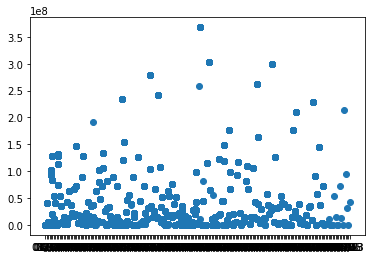

In [12]:
plt.scatter(x= tomatoes.month, y=tomatoes.box_office)